In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Banditen-Interface

Ein Bandit muss mindestens folgende Eigenschaften haben:

- es muss möglich sein, den Banditen zurück zu setzen 
- es muss möglich sein, eine Variante zu "versuchen" - pull
- es muss möglich sein, einer Variante einen Erfolg zurück zu melden - reward
- es muss möglich sein, dass der Bandit eine empfohlene Variante zurückgibt - get recommended arm - das ist im Reinforcement Learning Kontext die sogenannte Policy, die versucht, die beste Aktion für den aktuellen Status zu ermitteln.

In [2]:
class Bandit:
    
    def reset(self, numarms):
        raise NotImplementedError
        
    def pull(self, arm):
        raise NotImplementedError
        
    def reward(self, arm, amount):
        raise NotImplementedError
        
    def get_recommended_arm(self):
        raise NotImplementedError
        
    def get_name(self):
        raise NotImplementedError
        

# Random Bandit (Gleichverteilung)

Der Zufallsbandit bildet im Grunde einen A/B-Test ab: alle Varianten haben die gleiche Chance, gezogen zu werden, ganz unabhängig von den bislang gemessenen Erfolgen.

In [3]:
class RandomBandit(Bandit):
    
    def __init__(self, numarms):
        self.numarms = numarms        
        
    def get_name(self):
        return "random"
    
    def reset(self, numarms):
        self.numarms = numarms        
    
    def pull(self, arm):
        pass
    
    def reward(self, arm, amount):
        pass
    
    ''' Zufaelliger Arm '''
    def get_recommended_arm(self):
        return np.random.randint(self.numarms)

# Epsilon Greedy

Eigenschaften:
    
- die Rewards können eine beliebige Gestalt annehmen. Am besten untersucht sind Bernoulli-Rewards, also entweder 0 = kein Erfolg oder 1 = Erfolg
- es gibt einen festen Parameter $\epsilon$, dieser steuert die Wahrscheinlichkeit der Exploration. 
- 1-$\epsilon$ ist die Wahrscheinlichkeit, die aktuell beste Variante zu ziehen. Die beste Variante im e-Greedy Sinne ist schlicht die, die am meisten Erfolg gesammelt hat

In [4]:
class EpsilonGreedyBandit(Bandit):
    
    def __init__(self, numarms, epsilon):
        self.numarms = numarms
        self.epsilon = epsilon
        self.reset(numarms)
        
    def get_name(self):
        return "eps-greedy"
        
    def reset(self, numarms):
        self.trials = np.zeros(numarms)
        self.values = np.zeros(numarms)
    
    def pull(self, arm):
        self.trials[arm] = self.trials[arm] + 1
        
    def reward(self, arm, reward):
        n = self.trials[arm]
        if (n==0):
            n = 1
        value = self.values[arm]
        new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
        #new_value = np.exp(np.log((n-1)/float(n)) + np.log(value+0.00001)) + (np.exp(np.log(1/float(n))+np.log(reward)))
        #print arm, new_value, 
        self.values[arm] = new_value
        
    def get_recommended_arm(self):
        if (np.random.uniform() <= self.epsilon):
            return np.random.randint(self.numarms)
        else:
            #if (np.alltrue([False]+[x - self.values[0] < 0.00001 for x in self.values])):
            #    return np.random.randint(self.numarms)
            #else:
            return np.argmax(self.values)

# Bayesian Bandit

## "Klassischer" Bayesianischer Beta-Bandit

Wie im Lehrbuch. Beta-Verteilung. 

Der Bayes-Bandit hat folgende Eigenschaften:

- er modelliert den Glauben über die tatsächliche Erfolgsrate (bspw. CTR) über Beta-Verteilungen. Neue Evidenz ( = mehr Daten) führt zu einem gefestigterem Glauben - wie üblich beim Bayesianischen Lernen.
- Thompson-Sampling ist der Begriff für das Ziehen von Zufallszahlen aus diesen Verteilungen. Die größere gezogene Zufallszahl gewinnt. Es ist daher wahrscheinlicher, dass die bessere Variante häufiger gezogen wird, aber auch die schlechtere Variante bleibt in der Exploration
- die Exploration geht nach und nach zurück, da die Varianz der Beta-Verteilung rapide sinkt. D. h. die Chance, dass sich die Verteilungen über den Glauben einer tatsächlichen Erfolgsrate stark überlappen, sinkt. -> Der Bandit konvergiert zur optimalen Variante unter der Voraussetzung, dass die ground truth stationär ist
- bei nicht stationären Erfolgsraten (was in der freien Wildbahn die Regel ist) adaptiert sich der Bandit auf die wechselnden Bedingungen. Die Geschwindigkeit, mit der er dies tut, hängt jedoch von einigen Faktoren ab:
 - wie klein die Varianz bereits geworden ist
 - wie groß die Unterschiede zwischen den Verteilungen sind 

In [5]:
class BayesianBandit(Bandit):
        
    def __init__(self, numarms):
        self.reset(numarms)              

    def get_name(self):
        return "bayes-beta"
    
    def reset(self, numarms):
        self.trials = []
        self.successes = []
        self.numarms = numarms
        
        for i in range(0, numarms):            
            self.trials.append(0)
            self.successes.append(0)         
    
    def pull(self, arm):
        self.trials[arm] = self.trials[arm] + 1.0        
    
    def reward(self, arm, amount):
        self.successes[arm] = self.successes[arm] + amount
    
    def get_recommended_arm(self):
        
        max_arm = -1
        max_theta = -1
        
        for arm in range(0,self.numarms):
            theta = np.random.beta(.5 + self.successes[arm], .5 + self.trials[arm] - self.successes[arm])
            if (theta >= max_theta):
                max_theta = theta
                max_arm = arm
        
        return max_arm

# Reward Generatoren

Mit unterschiedlichen Reward Generatoren kann man unterschiedliche Bedingungen simulieren. Derzeit arbeiten wir nur mit Bernoulli-Rewards, also Folgen von 1.0 / 0.0 (Erfolg = ja / nein)

In [6]:
class RewardGenerator:
    
    def getCurrentCTR(self, step):
        return 0.0
    
    def getReward(self, step):   
        if (np.random.random() < self.getCurrentCTR(step)):
            return 1.0
        else:
            return 0.0    

Helfer, um sich die Reward-Generatoren ansehen zu können.

In [7]:
def plot_reward_generator(horizon, filename=None, **kwargs):
    
    plt.figure(figsize=(20,4))
    x = np.arange(0, horizon)    
    for k,v in kwargs.items():
        y = np.array([v.getCurrentCTR(step) for step in x])
        lenny = len(y)
        if (lenny>=100000):
            y = y[0:-1:10]
            x = x[0:-1:10]
        elif (lenny>=1000000):
            y = y[0:-1:100]
            x = x[0:-1:100]
        plt.plot(x,y, label=k)
        print (k, 'hat einen Mittelwert von', y.mean())
        
    plt.legend()
    
    if (filename):
        plt.savefig(filename)
    
    plt.show()
    
def plot_reward_generator_sample(horizon, **kwargs):
    plt.figure(figsize=(20,4))
    x = np.arange(0, horizon)    
    for k,v in kwargs.items():
        y = np.array([v.getReward(step) + np.random.random() * 0.2 for step in x])
        plt.plot(x,y, '*',label=k)
        print (k, 'hat einen Mittelwert von', y.mean())
        
    plt.legend()
    plt.show()
    

### Uniform Reward Generator

Repräsentiert eine stationäre Verteilung, d. h., zu jedem Zeitpunkt innerhalb des Horizontes gilt die gleiche CTR

In [8]:
class UniformRewardGenerator(RewardGenerator):
    
    def __init__(self, ctr):
        self.ctr = ctr
        
    def getCurrentCTR(self, step):
        return self.ctr  

uniform hat einen Mittelwert von 0.20000000000000004


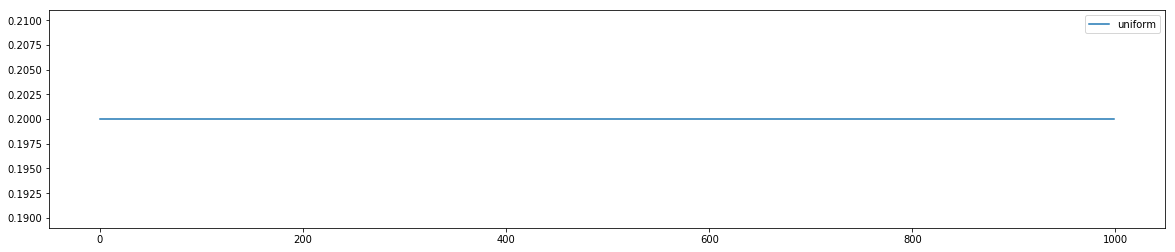

In [9]:
plot_reward_generator(1000, uniform=UniformRewardGenerator(0.2))

uniform hat einen Mittelwert von 0.365765008668854


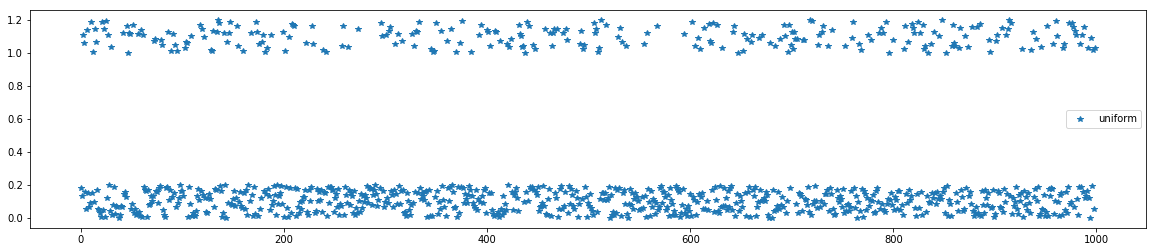

In [10]:
plot_reward_generator_sample(1000, uniform=UniformRewardGenerator(0.25))

### Linear Moving Reward Generator

Ermöglicht ein lineares An- bzw. Abschwellen der Rewards über den Zeithorizont.

In [11]:
class LinearMovingRewardGenerator(RewardGenerator):
    
    def __init__(self, ctrStart, ctrEnd, horizon):
        self.ctrStart = ctrStart
        self.ctrEnd = ctrEnd
        self.horizon = horizon
        self.stepSize = (self.ctrEnd - self.ctrStart) / self.horizon        
        
    def getCurrentCTR(self, step):
        return self.ctrStart + step * self.stepSize
  

aufsteigend hat einen Mittelwert von 0.49995
absteigend hat einen Mittelwert von 0.5000499999999999


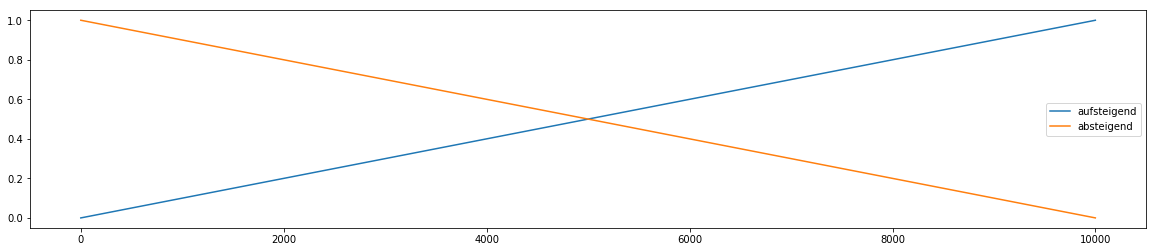

In [12]:
def test_LinearMovingGenerator():
    horizon = 10000
    start = 0.0
    end = 1.0
    
    # Aufsteigend
    linUP = LinearMovingRewardGenerator(start, end, horizon)    
    # Absteigende CTR
    linDOWN = LinearMovingRewardGenerator(end, start, horizon)
    
    plot_reward_generator(horizon, aufsteigend = linUP, absteigend = linDOWN)
    
test_LinearMovingGenerator()

lin hat einen Mittelwert von 0.6149175596215498


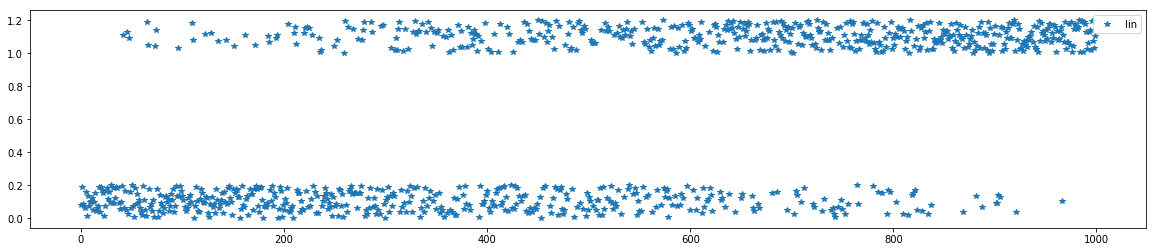

In [13]:
plot_reward_generator_sample(1000, lin = LinearMovingRewardGenerator(0.0,1.0,1000))

# Monte Carlo Testing

### Monte Carlo Simulation 

In [14]:
# Monte Carlo Code

from joblib import Parallel, delayed, cpu_count

def parallel_helper(obj, methodname, *args, **kwargs):
    """Helper to workaround Python 2 limitations of pickling instance methods"""
    return getattr(obj, methodname)(*args, **kwargs)

class MonteCarloResult:
    
    def __init__(self, identifier, cumulative_rewards, cumulative_arms_played):
        self.identifier = identifier
        self.cumulative_rewards = cumulative_rewards
        self.cumulative_arms_played = cumulative_arms_played                
        
class MonteCarloSimulationResult:
    
    def __init__(self, bandits, n_sims, horizon = 10000):
        self.bandits = bandits
        self.n_sims = n_sims
        self.horizon = horizon
        self.cumulative_rewards_by_bandit = {}
        self.cumulative_arms_played_by_bandit = {}
        for b in self.bandits:
            self.cumulative_rewards_by_bandit[b.get_name()] = np.array([])
            self.cumulative_arms_played_by_bandit[b.get_name()] = np.array([])
                    
    def add_result(self, singleresult):
        if (len(self.cumulative_rewards_by_bandit[singleresult.identifier])) == 0:
            self.cumulative_rewards_by_bandit[singleresult.identifier] = singleresult.cumulative_rewards.copy()
            self.cumulative_arms_played_by_bandit[singleresult.identifier] = singleresult.cumulative_arms_played.copy()
        else:
            self.cumulative_rewards_by_bandit[singleresult.identifier] = np.vstack((self.cumulative_rewards_by_bandit[singleresult.identifier], singleresult.cumulative_rewards.copy()))
            self.cumulative_arms_played_by_bandit[singleresult.identifier] += singleresult.cumulative_arms_played.copy()
            
    def cumulative_rewards_mean(self, banditname):
        return self.cumulative_rewards_by_bandit[banditname].mean(axis=0)
    
    def cumulative_rewards_all(self, banditname):
        return self.cumulative_rewards_by_bandit[banditname]
    
    def cumulative_arms_played(self, banditname):
        return self.cumulative_arms_played_by_bandit[banditname] / self.n_sims
    
from copy import copy

class MonteCarloSingleBanditTest:
    
    '''
    Initialisieren eines Tests gegen einen Banditen
    mit numarms Anzahl Armen
    unter Beachtung bestimmter Reward-Generatoren
    über einen bestimmten Horizont
    '''
    def __init__(self, 
                 bandit, 
                 numarms = 2, 
                 rewardgenerator = [UniformRewardGenerator(0.1), UniformRewardGenerator(0.2)], 
                 horizon = 10000):
        self.bandit = copy(bandit)
        self.numarms = numarms
        self.rewardgenerator = rewardgenerator
        self.horizon = horizon        
        
    def simulate(self):
        self.horizon_range = np.arange(0, self.horizon)
        self.recommended = np.zeros( (self.numarms, self.horizon ))
        self.all_rewards = np.zeros( self.horizon )
            
        self.bandit.reset(self.numarms)
        rewards = 0
        for h in self.horizon_range:
            arm = self.bandit.get_recommended_arm()
            self.recommended[arm,h] = self.recommended[arm,h] + 1.0
            self.bandit.pull(arm)
            current_reward = self.rewardgenerator[arm].getReward(h)
            if (current_reward > 0.0):
                rewards += current_reward            
                self.bandit.reward(arm, current_reward)
            self.all_rewards[h] = rewards
                
        return MonteCarloResult(self.bandit.get_name(), self.all_rewards, self.recommended)
    
    def __str__(self):
        return "Single-Test {0}".format(self.bandit.get_name())
    
class MonteCarloTest:
    
    def __init__(self, bandits, benchmark, rewardgenerators, horizon, n_jobs = -1, n_sims = 10, verbose = True):
        
        if not type(bandits) is list:
            raise ValueError("bandits must be a list of bandits")
            
        if not type(rewardgenerators) is list:
            raise ValueError("rewardgenerators must be a list of reward generators")
        
        self.horizon = horizon
        self.n_jobs = n_jobs
        if (n_jobs < 0):
            self.n_jobs = cpu_count()
        self.n_sims = n_sims 
        self.bandits = list(bandits)
        self.bandits.append(benchmark)
        self.benchmark = benchmark
        self.rewardgenerators = list(rewardgenerators)
        self.verbose = verbose
        self.results = {}
    
    def simulate(self):
        
        self.all_result = MonteCarloSimulationResult(self.bandits, n_sims = self.n_sims, horizon=self.horizon)
        self.n_bandits = len(self.bandits)
        self.n_all_simulations = self.n_bandits * self.n_sims
        
        self.jobs_collected = 0
        self.jobs = []
        self.count = 0
        if (self.verbose):
            print ('Starting Monte Carlo Test with %s Bandits in %s Simulations over a Horizon of %s' % (self.n_bandits,self.n_sims, self.horizon))
     
        for sim in range(0, self.n_sims):
            if (self.verbose):
                print ('Simulation #%s' % sim)
            else:
                print ('#', end=''),
            for b in self.bandits:
                if (self.verbose):
                    print ('... collecting Bandit ' + b.get_name())
                self.jobs_collected = self.jobs_collected + 1
                self.count += 1
                self.job = MonteCarloSingleBanditTest(bandit=b, horizon=self.horizon, numarms=b.numarms, rewardgenerator=self.rewardgenerators)
                self.jobs.append(self.job)
                if ((self.jobs_collected >= self.n_jobs) or (self.count >= self.n_all_simulations)):
                    if (self.verbose):
                        print ('>>> Starting Jobs in Parallel <<<')
                        for i in self.jobs:
                            print (i)
                    self.intermediate_results = Parallel(n_jobs=self.n_jobs)(delayed(j.simulate)() for j in self.jobs)
                    self.jobs_collected = 0
                    self.jobs = []
                    for one_result in self.intermediate_results:
                        #print one_result.identifier
                        self.all_result.add_result(one_result)
        if (self.verbose):
            print ('Work complete')
                        
        return self.all_result

### Monte Carlo Ergebnisse plotten 

In [15]:
# Monte Carlo Plotter

colors = ['red','orange', 'green', 'cyan', 'blue', 'violet', 'indigo', 'chocolate', 'coral', 'forestgreen', 'midnightblue','darkolivegreen','fuchsia','steelblue','sienna','grey','black']
linestyle = ['-','--','-.']

def plot_monte_carlo_rewards(result, axes = None, filename = None):

    if (axes == None):
        plt.figure(figsize=(16,9))
        ax = plt.gca()
    else:
        ax = axes
        
    x = np.arange(0, result.horizon)
    
    for bandit in result.bandits:
        banditname = bandit.get_name()
        ax.plot(x, result.cumulative_rewards_mean(banditname), label=banditname)
    
    ax.legend()
    
    if (filename):
        plt.savefig(filename)

def plot_monte_carlo_arms_played(result, axes = None, filename = None):
    
    if (axes == None):
        plt.figure(figsize=(16,9))
        ax = plt.gca()
    else:
        ax = axes
        
    x = np.arange(0, result.horizon)
    
    for b, bandit in enumerate(result.bandits):
        banditname = bandit.get_name()
        arms_played = result.cumulative_arms_played(banditname)
        for n in range(0, len(arms_played)):
            ax.plot(x, arms_played[n].cumsum(), linestyle=linestyle[n], color=colors[b], label="%s-%s" % (banditname,n))
    ax.legend(loc="upper left", bbox_to_anchor=(1,1))
    
    if (filename):
        plt.savefig(filename)

    
def plot_monte_carlo_totals(result, filename=None):
        
    plt.figure(figsize=(16,9))
    ax = plt.gca()
    
    random_total = result.cumulative_rewards_mean('random')[-1]
        
    x = [b.get_name() for b in result.bandits]    
    y = [result.cumulative_rewards_mean(b.get_name())[-1] - random_total for b in result.bandits]
    
    plt.bar(np.arange(len(x)), y, color='grey')
    plt.xticks(np.arange(len(x)), x, rotation=45)
    plt.axhline(y=0.)
    
    if (filename):
        plt.savefig(filename)

    

def plot_monte_carlo_reward_histograms(result):
    
    plt.figure(figsize=(16,9))
    
    random_total = result.cumulative_rewards_mean('random')[-1]
    
    x = [b.get_name() for b in result.bandits]
    for bandit in result.bandits:
        yy = result.cumulative_rewards_all(bandit.get_name())[:,-1]
        yy -= random_total
        print (bandit.get_name())
        plt.hist(yy,100,label=bandit.get_name(),alpha=0.7)
        plt.show()
        #print bandit.get_name(), yy
    plt.legend()    
    
    
def print_monte_carlo_results(id, result):
    
    lines = []
    
    lines.append("Monte Carlo Settings")
    lines.append("--------------------------------------------------------")
    
    lines.append("id=%s" % (id))
    lines.append("numsims=%s" %(result.n_sims))
    lines.append("horizon=%s" %(result.horizon))
    
    lines.append("")
    
    lines.append("Cumulative Rewards (over random selection) per Bandit")
    lines.append("--------------------------------------------------------")
    
    random_total = result.cumulative_rewards_mean('random')[-1]
    
    tuples = []
    
    for bandit in result.bandits:
        cum_reward = result.cumulative_rewards_mean(bandit.get_name())[-1]
        cum_reward -= random_total
        tuples.append( (bandit.get_name(), cum_reward) )
    
    tuples.sort(key=lambda x: x[1], reverse=True)
    
    for tup in tuples:
        lines.append("%40s : %10s" % (tup[0], tup[1]))
        
    return str.join("\n", lines)    

# Use Cases

In [16]:
horizon = 100000

In [17]:
simple_bandits = [
    EpsilonGreedyBandit(3, .05),
    BayesianBandit(3)
]

In [18]:
def test_and_plot(bandits_to_test, rewardgenerators, numsims=10, horizon=100000):
    test = MonteCarloTest(bandits=bandits_to_test, benchmark=RandomBandit(3), verbose = False, rewardgenerators=rewardgenerators, horizon=horizon, n_sims=numsims, n_jobs=-1)
    sim_result = test.simulate()
    print (print_monte_carlo_results('Simulation', sim_result))
    plot_monte_carlo_rewards(sim_result)
    plot_monte_carlo_arms_played(sim_result)

#### Lineare Click-Through-Rate (CTR)

In [19]:
static_ctr = [
    UniformRewardGenerator(0.24),
    UniformRewardGenerator(0.41),
    UniformRewardGenerator(0.55)
]

CTR_2 hat einen Mittelwert von 0.5499999999999999
CTR_0 hat einen Mittelwert von 0.2400000000000001
CTR_1 hat einen Mittelwert von 0.4100000000000001


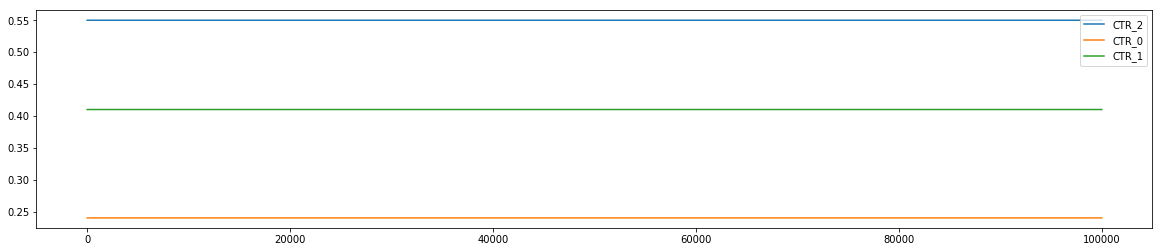

In [20]:
plot_reward_generator(horizon, CTR_0 = static_ctr[0], CTR_1 = static_ctr[1], CTR_2=static_ctr[2])

##########Monte Carlo Settings
--------------------------------------------------------
id=Simulation
numsims=10
horizon=100000

Cumulative Rewards (over random selection) per Bandit
--------------------------------------------------------
                              bayes-beta :    14862.0
                              eps-greedy :    12318.0
                                  random :        0.0


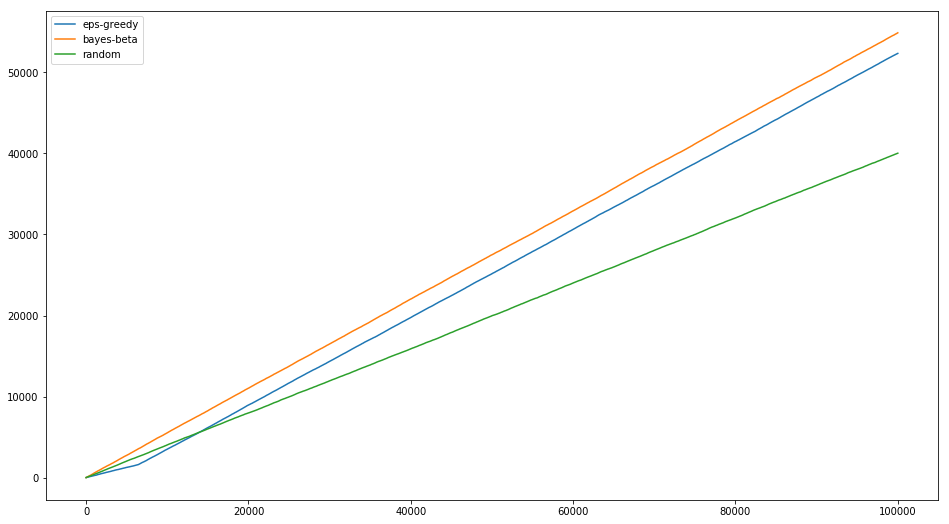

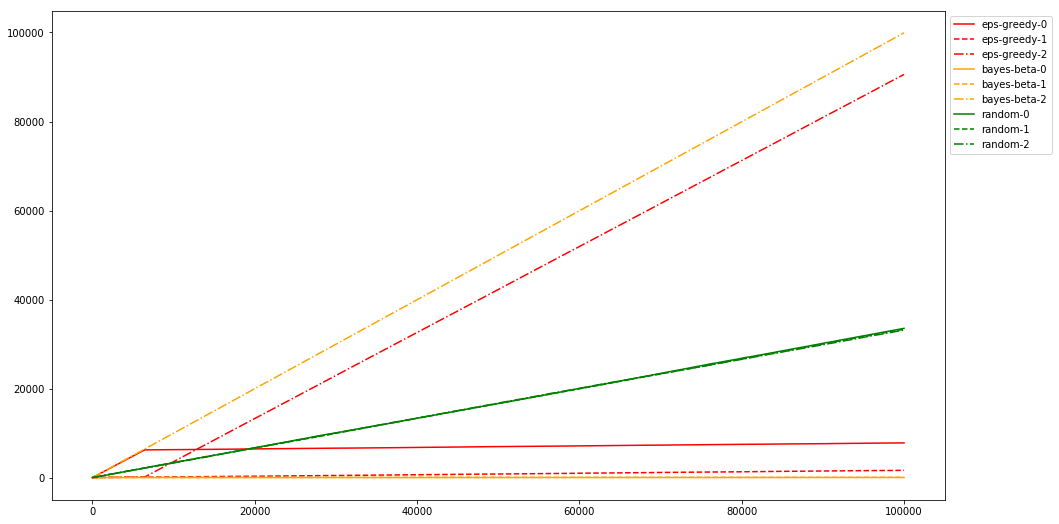

In [21]:
test_and_plot(simple_bandits, static_ctr, horizon=horizon)

#### Die offensichtliche Frage:
*Warum sich die Mühe machen, einen komplizierteren Algorithmus als den Bayesianischen Banditen zu entwickeln?*

#### Die ernüchternde Antwort:
*In der Realität finden wir selten (d.h. nie) ein gleichmäßiges Userverhalten *

In [22]:
linear_ctr = [
    UniformRewardGenerator(0.44),
    LinearMovingRewardGenerator(0.3, 0.5, horizon),
    LinearMovingRewardGenerator(0.55, 0.27, horizon)
]

CTR_2 hat einen Mittelwert von 0.41001400000000005
CTR_0 hat einen Mittelwert von 0.44000000000000017
CTR_1 hat einen Mittelwert von 0.39998999999999996


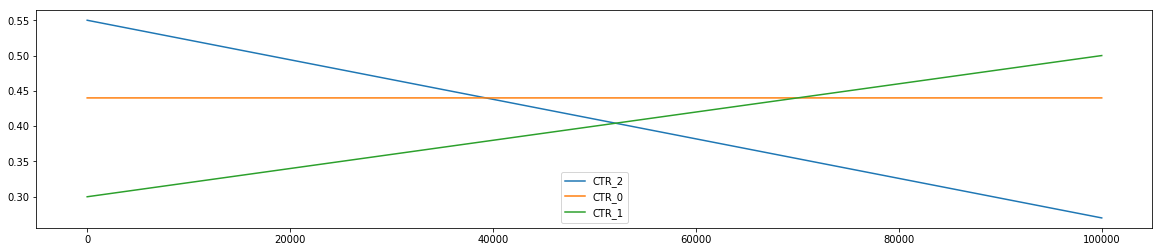

In [23]:
plot_reward_generator(horizon, CTR_0 = linear_ctr[0], CTR_1 = linear_ctr[1], CTR_2=linear_ctr[2])

##########Monte Carlo Settings
--------------------------------------------------------
id=Simulation
numsims=10
horizon=100000

Cumulative Rewards (over random selection) per Bandit
--------------------------------------------------------
                              eps-greedy :     2115.0
                              bayes-beta :     1842.0
                                  random :        0.0


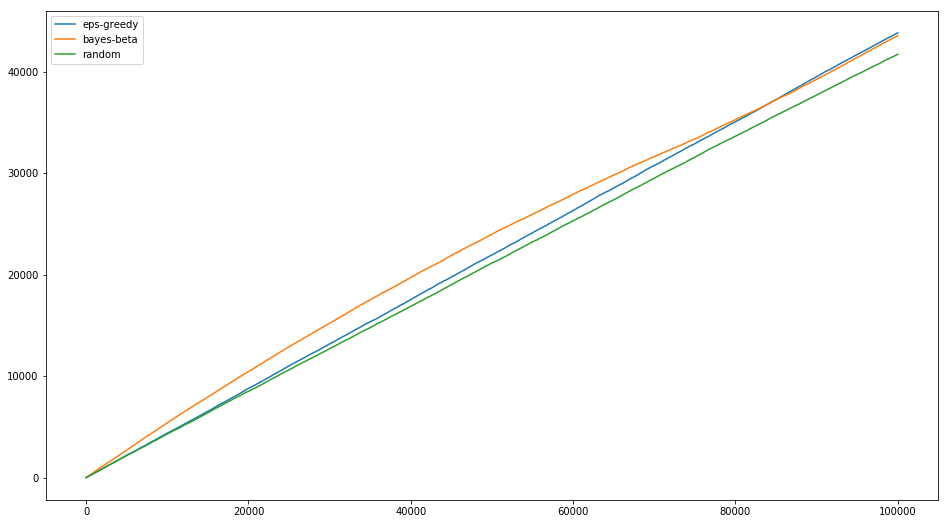

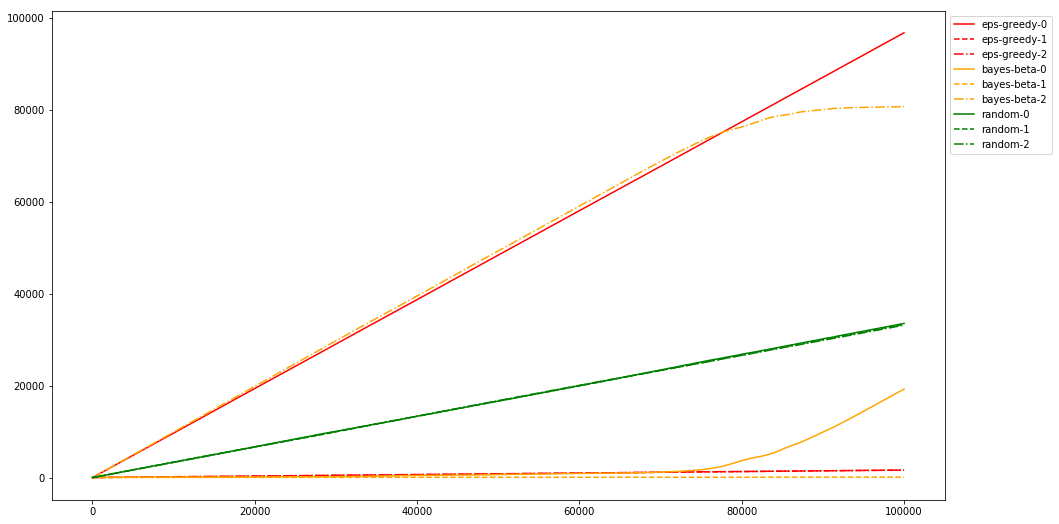

In [24]:
test_and_plot(simple_bandits, linear_ctr, horizon=horizon)

# Rollender Horizont

## Rolling Bayes Bandit

Der "rollende" Bayes Bandit betrachtet immer nur ein gleitendes Fenster an Rewards, und niemals den gesamten Horizont. Dadurch wird die Varianz nach unten begrenzt (je nach Größe des gleitenden Fensters).

In [25]:
class FixedBuffer():
    
    def __init__(self, capacity, weight = 1.0):
        self.capacity = capacity
        self.values = np.zeros(self.capacity)
        self.pointer = 0
        self.total = 0.
        self.countToCapacity = 0.
        self.weight = weight
                
    def append(self, value):
        if (self.countToCapacity < self.capacity):
            self.countToCapacity += 1.0
        self.total -= self.values[self.pointer]
        self.values[self.pointer] = value
        self.total += value
        self.pointer += 1
        if (self.pointer>=self.capacity):
            self.pointer = 0
                
    def sum(self):
        return self.total * self.weight
    
    def __str__(self):
        return 'fixed-buffer-sum %s' % (self.sum())

In [26]:
class BayesianApproxBandit(BayesianBandit):

    def get_name(self):
        return "bayes-beta-gauss"
    
    '''
    siehe https://de.wikipedia.org/wiki/Betaverteilung#Erwartungswert
    '''
    def get_mean(self, alpha, beta):
        return alpha / (alpha + beta)
    
    '''
    siehe https://de.wikipedia.org/wiki/Betaverteilung#Varianz
    '''
    def get_variance(self, alpha, beta):
        return ( (alpha * beta) / (( alpha + beta + 1. ) * (alpha+beta)**2) )
    
    def get_standard_deviation(self, alpha, beta):
        return np.sqrt(self.get_variance(alpha,beta))
    
    def get_recommended_arm(self):
        max_arm = -1
        max_theta = -1
        for arm in range(0,self.numarms):
            alpha = .5 + self.successes[arm]
            beta = .5 + self.trials[arm] - self.successes[arm]
            theta = np.random.normal(self.get_mean(alpha, beta), self.get_standard_deviation(alpha,beta))
            if (theta >= max_theta):
                max_theta = theta
                max_arm = arm
        
        return max_arm
        pass

In [27]:
class RollingBayesianBandit(BayesianApproxBandit):
    
    def get_name(self):
        return "rolling-limited-bayes-%s-%s" % (self.rolling_horizon, self.min_variance)
    
    def __init__(self, numarms, rolling_horizon = 1000, min_variance = 0.00):
        BayesianApproxBandit.__init__(self,numarms)
        self.rolling_horizon = rolling_horizon        
        self.buffer = [FixedBuffer(rolling_horizon) for i in range(0, numarms)]        
        self.min_variance = min_variance
        
    def pull(self, arm):
        self.buffer[arm].append(0.0)
        
    def reward(self, arm, reward):
        self.buffer[arm].append(1.0)
        
    def get_variance(self, alpha, beta):
        var = BayesianApproxBandit.get_variance(self,alpha,beta)
        if (var < self.min_variance):
            return self.min_variance
        else:
            return var
         
    def get_recommended_arm(self):
        max_arm = -1
        max_theta = -1
        for arm in range(0,self.numarms):
            alpha = .5 + self.buffer[arm].sum() # successes
            beta = .5 + self.rolling_horizon - self.buffer[arm].sum() # trials - successes
            theta = np.random.normal(self.get_mean(alpha, beta), self.get_standard_deviation(alpha,beta))
            if (theta >= max_theta):
                max_theta = theta
                max_arm = arm
        
        return max_arm
        pass
        

In [28]:
rolling_bandits = [
    EpsilonGreedyBandit(3, .1),
    BayesianBandit(3),
    RollingBayesianBandit(3, rolling_horizon=500)
]

##########Monte Carlo Settings
--------------------------------------------------------
id=Simulation
numsims=10
horizon=100000

Cumulative Rewards (over random selection) per Bandit
--------------------------------------------------------
                              bayes-beta :     1842.0
                                  random :        0.0
                              eps-greedy :     -630.0
           rolling-limited-bayes-500-0.0 :     -682.0


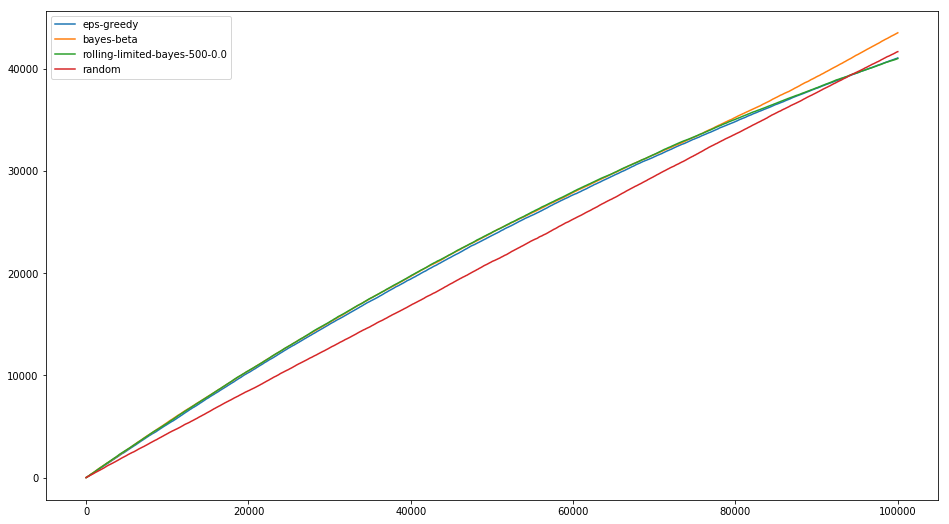

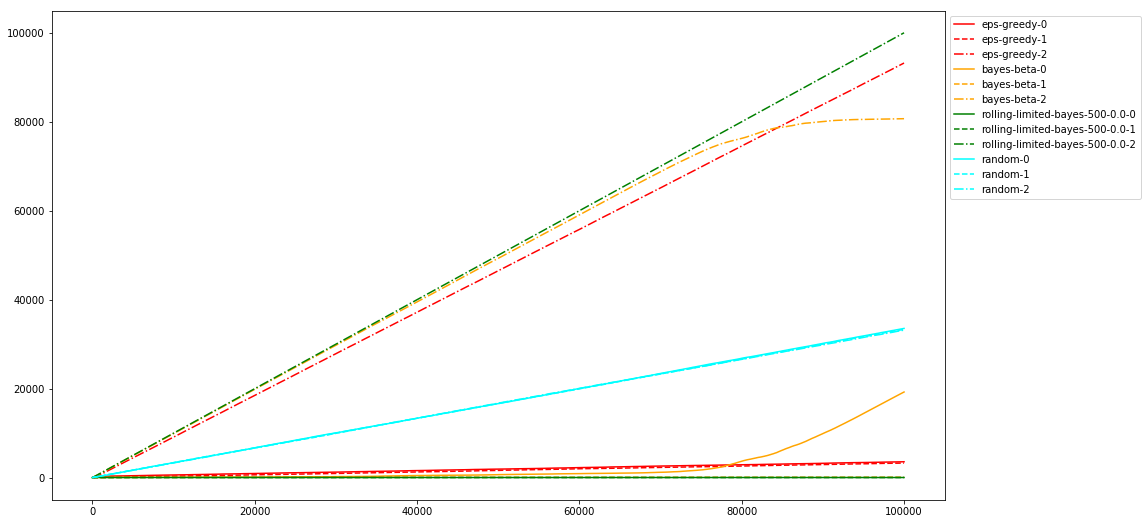

In [29]:
test_and_plot(rolling_bandits, linear_ctr, horizon=horizon)

# Gewichter Horizont

## Reaktiver Bandit

Der reaktive Bandit kombiniert eine kurze, eine mittlere und eine lange Sicht auf den Horizont.

In [30]:
class BayesianReactiveBandit(BayesianApproxBandit):

    def get_name(self):
        return "reactive-%s-%s" % (self.shortHorizon, self.longHorizon)
        
    def __init__(self, numarms, short_horizon = 100, long_horizon = 1000):
        BayesianApproxBandit.__init__(self, numarms)
        self.shortHorizon = short_horizon
        self.longHorizon = long_horizon
        self.buffer = [FixedBuffer(short_horizon) for i in range(0,numarms)]
        self.bufferLong = [FixedBuffer(long_horizon) for i in range(0,numarms)]
        toggle = False        
            
    def pull(self, arm):
        BayesianApproxBandit.pull(self, arm)
        self.buffer[arm].append(0.0)
        self.bufferLong[arm].append(0.0)
    
    def reward(self, arm, reward):
        BayesianApproxBandit.reward(self, arm, reward)
        self.buffer[arm].append(reward)
        self.bufferLong[arm].append(reward)
             
    def get_recommended_arm(self):
        max_arm = -1
        max_theta = -1
                
        for arm in range(0,self.numarms):
            alpha = .5 + self.successes[arm]
            beta = .5 + self.trials[arm] - self.successes[arm]
            
            meanShort = self.buffer[arm].sum() / self.shortHorizon
            meanLong = self.bufferLong[arm].sum() / self.longHorizon
            meanTotal = self.get_mean(alpha, beta)        
            meanCombined = 0.2 * meanTotal + 0.3 * meanLong + 0.5 * meanShort        
            
            theta = np.random.normal(meanCombined, self.get_standard_deviation(alpha,beta))
            if (theta >= max_theta):
                max_theta = theta
                max_arm = arm
        
        return max_arm
        
    

In [31]:
from functools import reduce

class BayesianReactive2Bandit(BayesianApproxBandit):

    def get_name(self):
        return "reactive2-%s-%s" % (self.horizons[0], self.weights[0]) 
        
    def __init__(self, numarms, horizons = [100, 1000, 15000], weights = [0.5, 0.3, 0.2]):
        BayesianApproxBandit.__init__(self, numarms)
        self.numarms = numarms
        self.n_buffers = len(horizons)
        self.horizons = np.array(horizons)
        self.weights = np.array(weights)
        self.w_horizons = self.weights * self.horizons
        self.w_horizons_sum = self.w_horizons.sum()
        self.rolls = [ [FixedBuffer(h,w) for h,w in zip(self.horizons,self.weights)] for n in range(0,self.numarms)]
        for i in range(0, self.n_buffers):
            for j in range(0, self.numarms):
                for k in range(0, self.horizons[i]):
                    self.rolls[j][i].append(0.5)
        
    def pull(self, arm):
        for i in range(0, self.n_buffers):
            self.rolls[arm][i].append(0.0)
        
    def reward(self, arm, reward):
        for i in range(0, self.n_buffers):
            self.rolls[arm][i].append(reward)
             
    def get_recommended_arm(self):
        max_arm = -1
        max_theta = -1
                
        for arm in range(0,self.numarms):
            
            alpha = .5 + self.w_horizons_sum
            beta = .5 + self.w_horizons_sum - reduce( (lambda x,y: x.sum() + y.sum()), self.rolls[arm] )
            
            mean = 0.0
            for i in range(0,self.n_buffers):
                mean += self.rolls[arm][i].sum() / self.horizons[i]
            
            theta = np.random.normal(mean, self.get_standard_deviation(alpha,beta))
            if (theta >= max_theta):
                max_theta = theta
                max_arm = arm
        
        return max_arm
        
    

In [32]:
weighted_bandits = [
    EpsilonGreedyBandit(len(static_ctr), .1),
    BayesianBandit(len(static_ctr)),
    RollingBayesianBandit(3, rolling_horizon=500),
    BayesianReactive2Bandit(3, horizons=[50,150,500], weights=[0.6,0.25,0.15])
]

##########Monte Carlo Settings
--------------------------------------------------------
id=Simulation
numsims=10
horizon=100000

Cumulative Rewards (over random selection) per Bandit
--------------------------------------------------------
                        reactive2-50-0.6 :     4035.0
                              bayes-beta :     1842.0
                                  random :        0.0
                              eps-greedy :     -630.0
           rolling-limited-bayes-500-0.0 :     -682.0


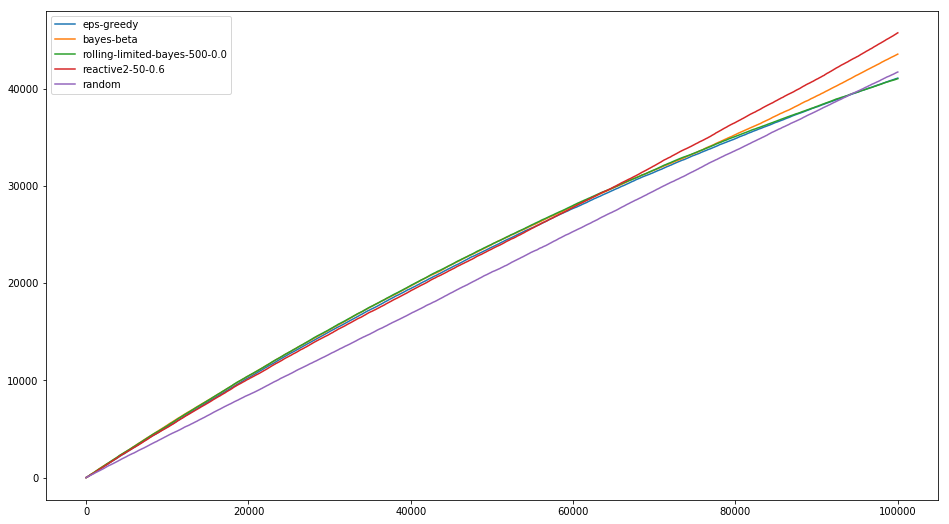

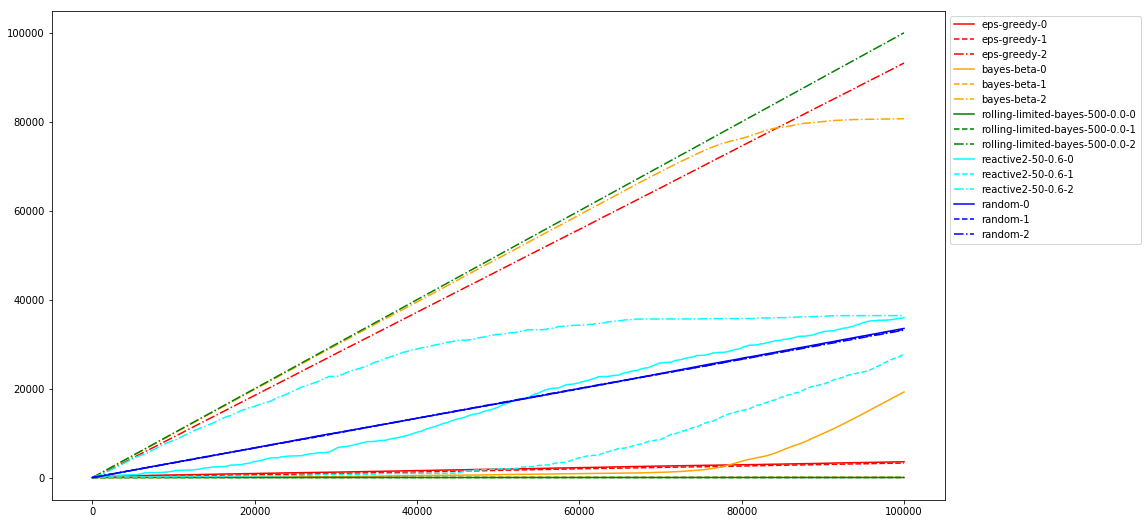

In [33]:
test_and_plot(weighted_bandits, linear_ctr, horizon=horizon)

# Realistischere CTR-Szenarien

### Peaking Reward Generator

Kurze Spitzen - und der Horizont. Das verändert alles.

In [34]:
class PeakingRewardGenerator(RewardGenerator):
    
    '''
    schwanke zwischen ctrMin und ctrMax
    innerhalb eines Horizontes
    beginne bei fractionStart % des Horizonts (0.0 < fractionStart < 1.0)
    für eine Länge von fractionLength % des Horizontes  (0.0 < fractionLength < 1.0)
    '''
    def __init__(self, ctrMin, ctrMax, horizon, fractionStart, fractionLength):
        self.ctrMin = ctrMin
        self.ctrMax = ctrMax
        self.horizon = horizon        
        self.fractionStart = fractionStart
        self.fractionLength = fractionLength
        
        self.startStep = fractionStart * horizon
        self.endStep = fractionLength * horizon + self.startStep
        self.middleStep = (self.startStep + self.endStep) / 2.0        
        
    def getCurrentCTR(self, step):
        if (step < self.startStep or step > self.endStep):
            return self.ctrMin
        else:
            return self.ctrMax

spaet hat einen Mittelwert von 0.7999
frueh hat einen Mittelwert von 0.2001


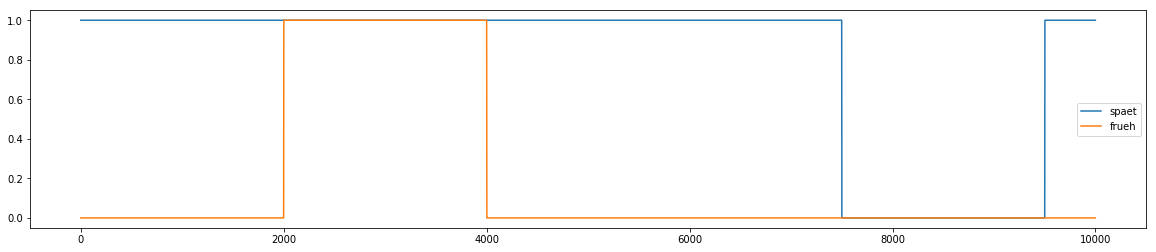

In [35]:
def test_PeakingGenerator():

    horizon = 10000
    start = 0.0
    end = 1.0
    
    '''Peek früher'''
    peekEarly = PeakingRewardGenerator(start, end, horizon, 0.20, 0.2)
    
    '''Peek später'''
    peekLate = PeakingRewardGenerator(end, start, horizon, 0.75, 0.2)

    plot_reward_generator(horizon, frueh = peekEarly, spaet = peekLate)
    
test_PeakingGenerator()

### Random Walk Reward Simulator

In [36]:
class RandomWalkRewardGenerator(RewardGenerator):
    
    def __init__(self, ctrMin, ctrMax, stepSize = 0.01):
        self.ctrMin = ctrMin
        self.ctrMax = ctrMax
        self.ctrMean = (self.ctrMin + self.ctrMax) / 2.0
        self.ctrDistance = self.ctrMax - self.ctrMin
        self.currentCTR = self.ctrMean - np.random.random() * self.ctrDistance
        if (self.currentCTR < 0.):
            self.currentCTR = self.ctrMean
        self.flipUp = 0.5
        self.nuance = np.absolute(ctrMax - ctrMin) * stepSize
    
    def _getFlipUp(self):
        return 0.5
    
    def getCurrentCTR(self, step):        
        coin = np.random.random() 
        
        step = np.random.normal() * self.nuance
        if (coin < self._getFlipUp()):
            if ((self.currentCTR + step) >= self.ctrMax):
                return self.currentCTR
            else:
                self.currentCTR = self.currentCTR + step            
        else:
            if ((self.currentCTR - step) < self.ctrMin):
                return self.currentCTR
            else:
                self.currentCTR = self.currentCTR - step            
                
        return self.currentCTR

### Frozen Reward Generator

Einfach nur eine vorgefertigte Liste mit CTRs, um bspw. einen Random Walk (siehe unten) einzufrieren. Ein eingefrorener Random Walk kann also mehrfach verwendet werden, ohne dass sich der Verlauf ändert. Man kann aber jeden beliebigen RewardGenerator damit wrappen.

In [37]:
class FrozenRewardGenerator(RewardGenerator):
    
    def __init__(self, rgen, horizon):
        self.rgen = rgen
        self.horizon = horizon
        self.ctr = np.array([rgen.getCurrentCTR(step) for step in np.arange(0, horizon)])
        
    def getCurrentCTR(self, step):
        return self.ctr[step]

In [38]:
walk1 = FrozenRewardGenerator(RandomWalkRewardGenerator(0.04, 0.12, stepSize=0.0028), horizon=10000)

RandomWalk hat einen Mittelwert von 0.08227497375136449


<Figure size 864x648 with 0 Axes>

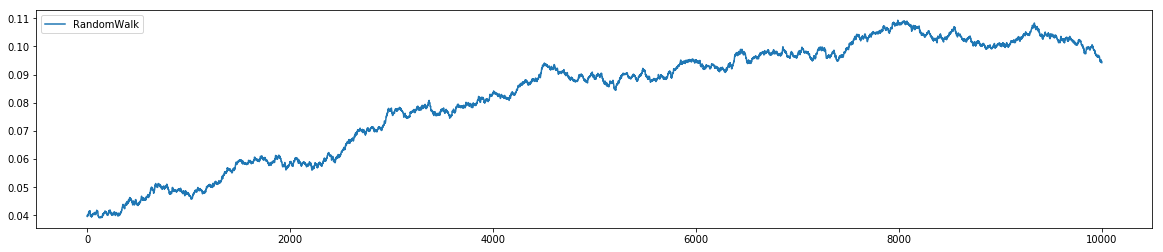

In [39]:
plt.figure(figsize=(12,9))
plot_reward_generator(10000, RandomWalk = walk1)

### Simulation eines verzögerten Ansteigens der gemessenen CTR  

In der Wirklichkeit kann es dauern zwischen dem Versuch ("Trial") und den später erst eintrudelnden Erfolgen ("Reward"). 

In [40]:
class FrozenDelayRewardGenerator(RewardGenerator):
    
    def __init__(self, rgen, horizon):
        self.rgen = rgen
        self.horizon = horizon
        self.ctr = np.array([rgen.getCurrentCTR(step) for step in np.arange(0, horizon)])
        
    def getDelay(self, step):
        return 1. / (1. + np.exp((self.horizon/3. + -step)/(self.horizon/10.)))
        
    def getCurrentCTR(self, step):
        return self.getDelay(step) * self.ctr[step]

In [41]:
delay = FrozenDelayRewardGenerator(UniformRewardGenerator(0.3), 10000)

delayed hat einen Mittelwert von 0.1989721179215019


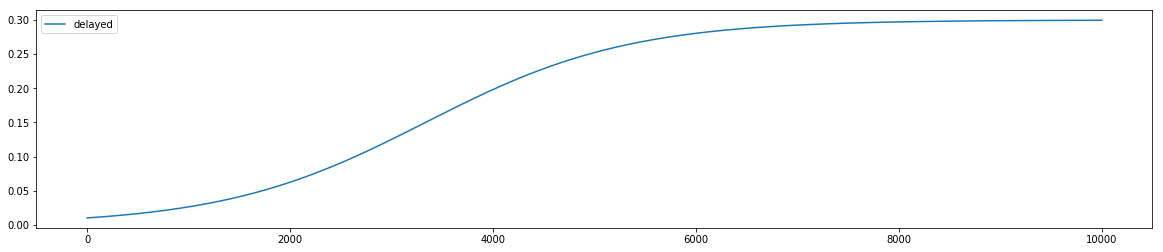

In [42]:
plot_reward_generator(10000,delayed=delay)

Mit den Wrappern können wir so nun zum bspw. auch einen RandomWalk in einem FrozenDelay verpacken, so dass auch ein Random Walk langsam ansteigen kann.

In [43]:
frozenwalk = FrozenDelayRewardGenerator(RandomWalkRewardGenerator(0.08, 0.12, stepSize=0.02), 10000)

frozenwalk hat einen Mittelwert von 0.06068247746814576


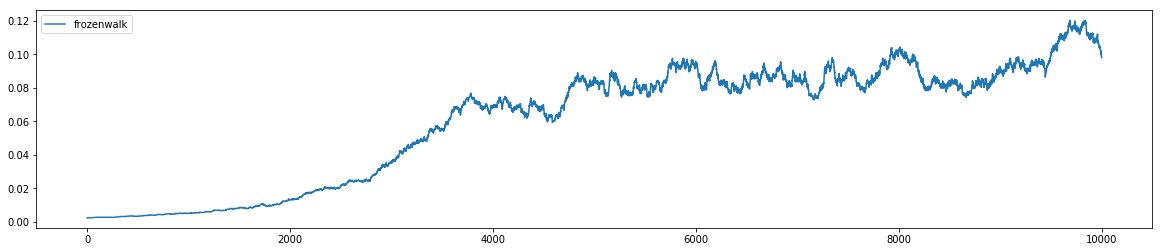

In [44]:
plot_reward_generator(10000, frozenwalk=frozenwalk)

### Simulation eines wobbeligen Rhythmus

Saisonale Trends kennen wir alle: insbesondere der Tag/Nacht-Rhythmus wäre hier als Beispiel zu nennen.

In [45]:
class FrozenWaveRewardGenerator(RewardGenerator):
    
    def __init__(self, rgen, horizon, wobbles = 7.):
        self.rgen = rgen
        self.horizon = horizon
        self.wobbles = wobbles * 2.
        self.ctr = np.array([rgen.getCurrentCTR(step) for step in np.arange(0, horizon)])
        
    def getWave(self, step):
        return 0.5 + np.cos(step / (self.horizon / self.wobbles) * 3.141) * 0.35
    
    def getCurrentCTR(self, step):
        return self.getWave(step) * self.ctr[step]

In [46]:
wobble = FrozenWaveRewardGenerator(delay,10000)

wobble hat einen Mittelwert von 0.09944448561555158


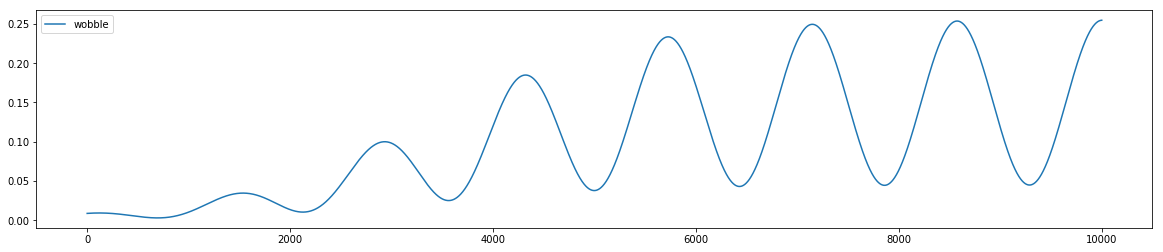

In [47]:
plot_reward_generator(10000, wobble = wobble)

# Versuch eines realistischen Szenarios

CTR_2 hat einen Mittelwert von -0.03338651943885017
CTR_0 hat einen Mittelwert von 0.15016049767285367
CTR_1 hat einen Mittelwert von 0.18489069990303714


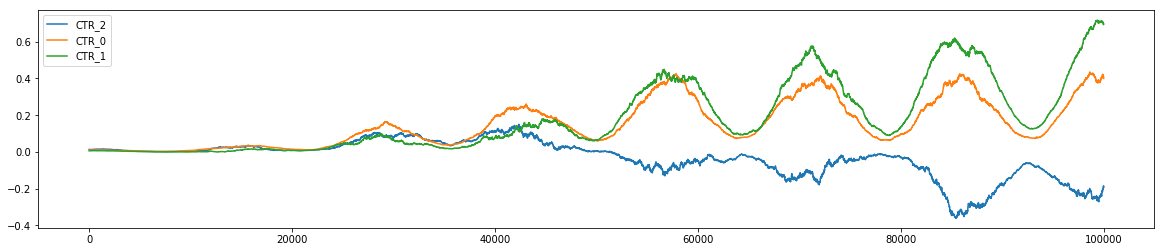

In [55]:
walk1 = FrozenRewardGenerator(RandomWalkRewardGenerator(ctrMin=0.4, ctrMax=0.5, stepSize=0.012351), horizon)
walk2 = FrozenRewardGenerator(RandomWalkRewardGenerator(ctrMin=0.2, ctrMax=0.8, stepSize=0.00251), horizon)
walk3 = FrozenRewardGenerator(RandomWalkRewardGenerator(ctrMin=0.4, ctrMax=0.6, stepSize=0.011825), horizon)

real_ctr = [
    walk1,
    walk2,
    walk3
]

real_ctr = [FrozenWaveRewardGenerator(gen, horizon) for gen in real_ctr]
real_ctr = [FrozenDelayRewardGenerator(gen, horizon) for gen in real_ctr]
plot_reward_generator(horizon, CTR_0 = real_ctr[0], CTR_1 = real_ctr[1], CTR_2=real_ctr[2])

##########Monte Carlo Settings
--------------------------------------------------------
id=Simulation
numsims=10
horizon=100000

Cumulative Rewards (over random selection) per Bandit
--------------------------------------------------------
                        reactive2-50-0.6 :     7722.0
                              bayes-beta :     3194.0
           rolling-limited-bayes-500-0.0 :     3016.0
                                  random :        0.0
                              eps-greedy :    -8846.0


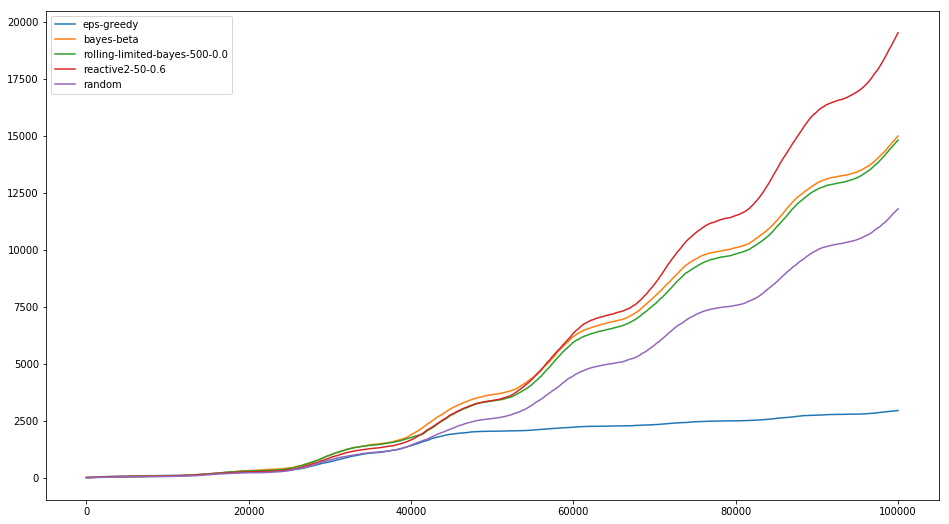

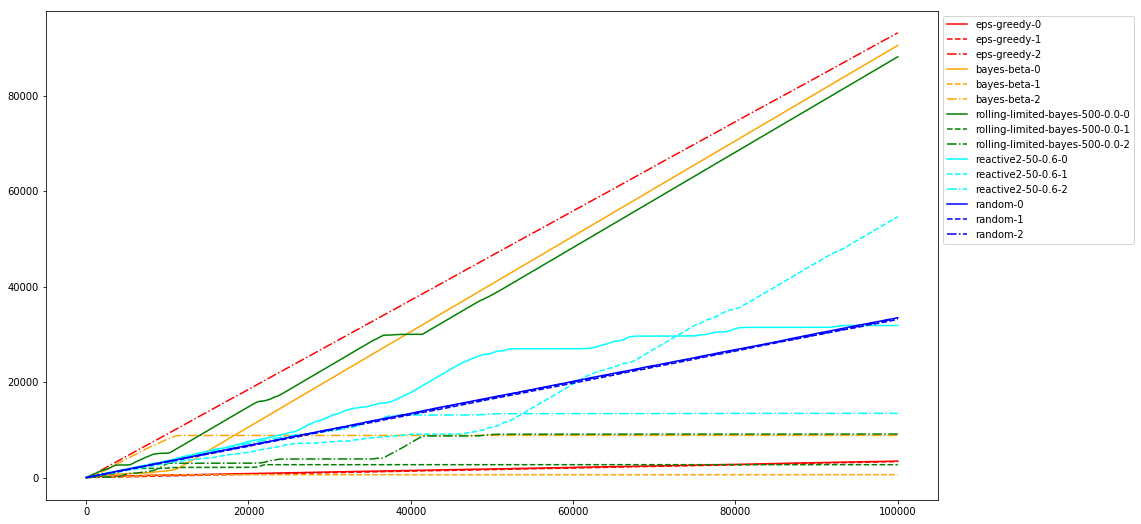

In [56]:
test_and_plot(weighted_bandits, real_ctr, horizon=horizon)